# Train PINN to recover a parameter

In this notebook we attempt to estimate the solution to a Harmonic oscillator system (see the data notebook), and invert the parameter $\mu$.

## Inputs
- Data, which include many measurement of the oscillator from $t=0$ to $t=1$
- The differential equation
- The initial conditions

## Outputs
- Estimation of the solution, eg. $x(t)$

## Approach

The PIML model is trained to approximate the solution to the DE, i.e.:

$$
x_{PIML}(t,\theta) \approx x(t)~,
$$
Where $\theta$ are the parameters to train.

For the parameter $\mu$, we also treat it as a trainable parameter, will be optimised pararelly with $\theta$.

## Loss function
To simulate the system, we will be using a loss function that satisfy:
1. The differential equation as physics loss
2. MSE loss function to ensure the prediction reflects to the known data

The Loss at $\theta$ is thus:
$$
\mathcal{L}(\theta) 
= 
\frac{\lambda_1}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] x_{\mathrm{PINN}}(t_{i};\theta)  \right)^2 \\
+ \frac{\lambda_1}{M} \sum^{M}_{i} MSE(x_{PIML}(t_i,\theta), x(t_i))
$$

To which, we include the initial conditions as the first two terms as can be seen, the third term ensure PINN solution to obey the DE at any training point. We include two hyperparameters $\lambda_1$ and $\lambda_2$, are used to balance the terms in the loss function.

In [8]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

from data import harmonic_oscillator_solution
from lossfn import mse, boundary_loss, physics_loss, physics_loss_imp
from model import FCN
from utils import backend_check

from IPython.display import clear_output

torch.manual_seed(123)

In [9]:
device = backend_check()

Backend check
Backend detected: mps
Use .to(device) to send vectors to backend!


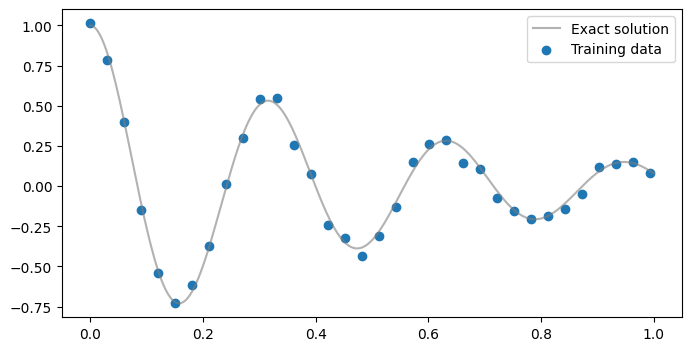

In [10]:
data = pd.read_csv('./time-oscillation.csv', dtype=np.float32)

d, w0 = 2, 20
t_true = torch.linspace(0,1,500).view(-1,1)
obs_true = harmonic_oscillator_solution(d, w0, t_true)

t_data = torch.tensor(data['t'][::9].values).view(-1,1)
obs_data = torch.tensor(data['observation'][::9].values).view(-1,1)

plt.figure(figsize=(8,4))
plt.plot(t_true, obs_true.view(-1,1), color="tab:grey", alpha=0.6, label="Exact solution")
plt.scatter(t_data, obs_data, label="Training data")
plt.legend()
plt.show()

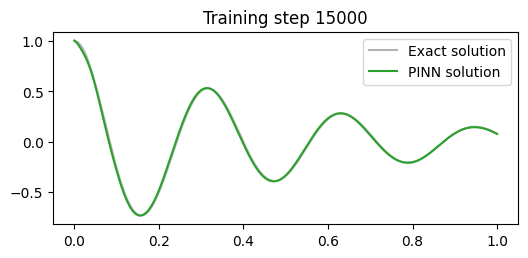

In [11]:
# Neural Network to train
pinn = FCN(N_INPUT=1, N_OUTPUT=1, N_HIDDEN=32, N_LAYERS=3).to(device=device)

# Send data to device
t_data_device = t_data.requires_grad_(True).to(device)
obs_data_device = obs_data.to(device)
t_true_device = t_true.to(device)
obs_true_device = obs_true.to(device)


d = 2
w0 = 20
_ = 2*d # now mu is considered missing :)
k = w0**2

mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True, device=device)) # mu is missing, let's train it!
all_mus = []

learning_rate=1e-3
optimiser = torch.optim.Adam(list(pinn.parameters()) + [mu], lr=learning_rate) # Notice mu in the optimiser

lambda1 = 1e-4
lambda2 = 1

for i in range(15001):
    optimiser.zero_grad()

    # Physics loss with DE
    prediction = pinn(t_data_device)
    loss3 = physics_loss(prediction, t_physics=t_data_device, mu=mu, k=k)

    # Combine loss
    loss:torch.Tensor = lambda1*loss3 +  lambda2*mse(prediction, obs_data_device)

    loss.backward()

    optimiser.step()

    all_mus.append(mu.item())

    # plot the result as training progresses
    if i % 1 == 0: 
        clear_output(wait=True)
        prediction = pinn(t_true_device).detach()
        plt.figure(figsize=(6,2.5))
        plt.plot(t_true[:,0], obs_true[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_true[:,0], prediction[:,0].cpu(), label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()


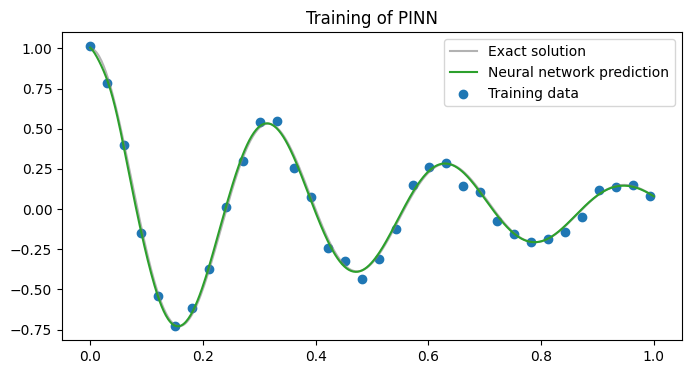

In [12]:
def plot_result(x,y,x_data,y_data,yh, title=None):

    plt.figure(figsize=(8,4))
    plt.title(title)
    plt.plot(x,y, color="tab:grey", alpha=0.6, label="Exact solution")
    plt.plot(x,yh, color="tab:green", label="Neural network prediction")
    plt.scatter(x_data, y_data, label='Training data')
    l = plt.legend(loc='best')

plot_result(
    t_true.detach(),
    obs_true.detach(),
    t_data.detach(),
    obs_data.detach(),
    prediction.cpu(),
    title='Training of PINN'
    )

mu = Parameter containing:
tensor([3.9985], device='mps:0', requires_grad=True)


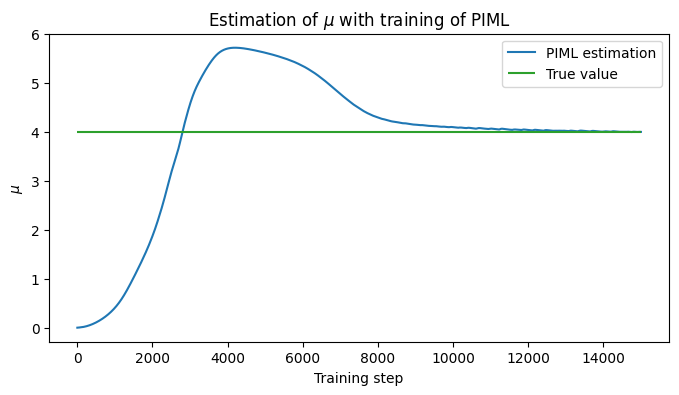

In [13]:
print(f'mu = {mu}')

plt.figure(figsize=(8,4))
plt.title("Estimation of $\mu$ with training of PIML")
plt.plot(all_mus, label="PIML estimation")
plt.hlines(2*d, 0, len(all_mus), label="True value", color="tab:green")
plt.legend(loc='best')
plt.xlabel("Training step")
plt.ylabel("$\mu$")
plt.show()

In [15]:
## MSE
np.mean((harmonic_oscillator_solution(d=2, w0=20, t=t_true) - pinn.cpu()(t_true)).detach().numpy())**2

6.96366885577504e-06